# 训练与预测验证

在完成数据预处理，数据加载与模型的组建后，你就可以进行模型的训练与预测了。飞桨主框架提供了两种训练与预测的方法，一种是用 [paddle.Model](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/Model_cn.html) 对模型进行封装，通过高层API如 [Model.fit](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/Model_cn.html#fit-train-data-none-eval-data-none-batch-size-1-epochs-1-eval-freq-1-log-freq-10-save-dir-none-save-freq-1-verbose-2-drop-last-false-shuffle-true-num-workers-0-callbacks-none) 、 [Model.evaluate](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/Model_cn.html#evaluate-eval-data-batch-size-1-log-freq-10-verbose-2-num-workers-0-callbacks-none) 、 [Model.predict](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/Model_cn.html#predict-test-data-batch-size-1-num-workers-0-stack-outputs-false-callbacks-none) 等完成模型的训练与预测；另一种就是基于基础API常规的训练方式。

高层API实现的模型训练与预测如 `Model.fit` 、 `Model.evaluate` 、 `Model.predict` 都可以通过基础API实现，本文先介绍高层API的训练方式，然后会将高层API拆解为基础API的方式，方便对比学习。

## 一、训练前准备

在封装模型前，需要先完成数据的加载，由于这一部分高层API与基础API通用，所以都可用下面的代码实现：

In [1]:
import paddle
import numpy as np
from paddle.vision.transforms import ToTensor

# 加载数据集
train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=ToTensor())
test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=ToTensor())

通过上述的代码，你就完成了训练集与测试集的构建，下面分别用两种方式完成模型的训练与预测。

## 二、通过 `paddle.Model` 训练与预测

在这里你可以采用Sequential组网或者SubClass组网的方式来创建一个mnist网络模型，你可使用 `paddle.Model` 完成模型的封装，将网络结构组合成一个可快速使用高层API进行训练和预测的对象。代码如下：

In [2]:
mnist = paddle.nn.Sequential(
    paddle.nn.Flatten(1, -1), 
    paddle.nn.Linear(784, 512), 
    paddle.nn.ReLU(), 
    paddle.nn.Dropout(0.2), 
    paddle.nn.Linear(512, 10)
)

model = paddle.Model(mnist)

W1222 09:27:56.863570  7417 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.2, Runtime API Version: 10.2
W1222 09:27:56.870544  7417 device_context.cc:465] device: 0, cuDNN Version: 7.6.


### 2.1 用 `Model.prepare` 配置模型

用 `paddle.Model` 完成模型的封装后，在训练前，需要对模型进行配置，通过 [Model.prepare](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/Model_cn.html#prepare-optimizer-none-loss-none-metrics-none-amp-configs-none) 接口来对训练进行提前的配置准备工作，包括设置模型优化器，Loss计算方法，精度计算方法等。

In [3]:
# 为模型训练做准备，设置优化器，损失函数和精度计算方式
model.prepare(optimizer=paddle.optimizer.Adam(parameters=model.parameters()), 
              loss=paddle.nn.CrossEntropyLoss(), 
              metrics=paddle.metric.Accuracy())

### 2.2 用 `Model.fit` 训练模型

做好模型训练的前期准备工作后，调用 `fit` 接口来启动训练过程，需要指定至少3个关键参数：训练数据集，训练轮次和单次训练数据批次大小。

In [4]:
# 启动模型训练，指定训练数据集，设置训练轮次，设置每次数据集计算的批次大小，设置日志格式
model.fit(train_dataset, 
          epochs=5, 
          batch_size=64,
          verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/5


/usr/local/python3.7.0/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and


step 938/938 [==============================] - loss: 0.1663 - acc: 0.9299 - 32ms/step          
Epoch 2/5
step 938/938 [==============================] - loss: 0.0393 - acc: 0.9689 - 32ms/step          
Epoch 3/5
step 938/938 [==============================] - loss: 0.0341 - acc: 0.9774 - 32ms/step          
Epoch 4/5
step 938/938 [==============================] - loss: 0.0118 - acc: 0.9827 - 32ms/step          
Epoch 5/5
step 938/938 [==============================] - loss: 0.1354 - acc: 0.9865 - 33ms/step          


### 2.3 用 `Model.evaluate` 评估模型

对于训练好的模型进行评估可以使用 `evaluate` 接口，事先定义好用于评估使用的数据集后，直接调用 `evaluate` 接口即可完成模型评估操作，结束后根据在 `prepare` 中 `loss` 和 `metric` 的定义来进行相关评估结果计算返回。

返回格式是一个字典:
* 只包含loss， `{'loss': xxx}` 
* 包含loss和一个评估指标， `{'loss': xxx, 'metric name': xxx}` 
* 包含loss和多个评估指标， `{'loss': xxx, 'metric name1': xxx, 'metric name2': xxx}` 

In [5]:
# 用 evaluate 在测试集上对模型进行验证
eval_result = model.evaluate(test_dataset, verbose=1)
print(eval_result)

Eval begin...
step 10000/10000 [==============================] - loss: 4.7684e-07 - acc: 0.9816 - 3ms/step          
Eval samples: 10000
{'loss': [4.7683704e-07], 'acc': 0.9816}


### 2.4 用 `Model.predict` 预测模型

高层API中提供了 `predict` 接口来方便用户对训练好的模型进行预测验证，只需要基于训练好的模型将需要进行预测测试的数据放到接口中进行计算即可，接口会将经过模型计算得到的预测结果进行返回。

返回格式是一个list，元素数目对应模型的输出数目：
* 模型是单一输出：`[(numpy_ndarray_1, numpy_ndarray_2, …, numpy_ndarray_n)]`
* 模型是多输出：`[(numpy_ndarray_1, numpy_ndarray_2, …, numpy_ndarray_n), (numpy_ndarray_1, numpy_ndarray_2, …, numpy_ndarray_n), …]`

numpy_ndarray_n是对应原始数据经过模型计算后得到的预测数据，数目对应预测数据集的数目。

Predict begin...
step 10000/10000 [==============================] - 2ms/step          
Predict samples: 10000
true label: 7, pred label: 7


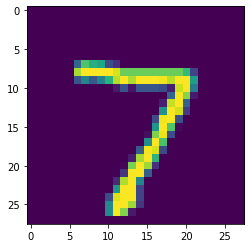

In [6]:
# 用 predict 在测试集上对模型进行测试
test_result = model.predict(test_dataset)

# 从测试集中取出一张图片
img, label = test_dataset[0]

# 执行推理并打印结果
pred_label = test_result[0][0].argmax()
print('true label: {}, pred label: {}'.format(label[0], pred_label))
# 可视化图片
from matplotlib import pyplot as plt
plt.imshow(img[0])

## 三、通过基础API实现模型的训练与预测

除了通过第一部分的高层API实现模型的训练与预测，飞桨框架也同样支持通过基础API对模型进行训练与预测。简单来说， `Model.prepare` 、 `Model.fit` 、 `Model.evaluate` 、 `Model.predict` 都是由基础API封装而来。下面通过拆解高层API到基础API的方式，来了解如何用基础API完成模型的训练与预测。

In [7]:
# 定义网络结构( 采用SubClass 组网 )
class Mnist(paddle.nn.Layer):
    def __init__(self):
        super(Mnist, self).__init__()
        self.flatten = paddle.nn.Flatten()
        self.linear_1 = paddle.nn.Linear(784, 512)
        self.linear_2 = paddle.nn.Linear(512, 10)
        self.relu = paddle.nn.ReLU()
        self.dropout = paddle.nn.Dropout(0.2)
            
    def forward(self, inputs):
        y = self.flatten(inputs)
        y = self.linear_1(y)
        y = self.relu(y)
        y = self.dropout(y)
        y = self.linear_2(y)
        return y

### 3.1 拆解 `Model.prepare` 、 `Model.fit` -- 用基础API训练模型

飞桨框架通过基础API对模型进行训练与预测，对应第一部分的 `Model.prepare` 与 `Model.fit` ：

In [8]:
# dataset与mnist的定义与第一部分内容一致
# 用 DataLoader 实现数据加载
train_loader = paddle.io.DataLoader(train_dataset, batch_size=64, shuffle=True)

mnist=Mnist()
mnist.train()

# 设置迭代次数
epochs = 5

# 设置优化器
optim = paddle.optimizer.Adam(parameters=mnist.parameters())
# 设置损失函数
loss_fn = paddle.nn.CrossEntropyLoss()
for epoch in range(epochs):
    for batch_id, data in enumerate(train_loader()):
        
        x_data = data[0]            # 训练数据
        y_data = data[1]            # 训练数据标签
        predicts = mnist(x_data)    # 预测结果  
        
        # 计算损失 等价于 prepare 中loss的设置
        loss = loss_fn(predicts, y_data)
        
        # 计算准确率 等价于 prepare 中metrics的设置
        acc = paddle.metric.accuracy(predicts, y_data)
        
        # 下面的反向传播、打印训练信息、更新参数、梯度清零都被封装到 Model.fit() 中
        # 反向传播 
        loss.backward()
        
        if (batch_id+1) % 900 == 0:
            print("epoch: {}, batch_id: {}, loss is: {}, acc is: {}".format(epoch, batch_id+1, loss.numpy(), acc.numpy()))
        # 更新参数 
        optim.step()
        # 梯度清零
        optim.clear_grad()

epoch: 0, batch_id: 900, loss is: [0.03877499], acc is: [1.]
epoch: 1, batch_id: 900, loss is: [0.04977579], acc is: [0.984375]
epoch: 2, batch_id: 900, loss is: [0.01578258], acc is: [1.]
epoch: 3, batch_id: 900, loss is: [0.10209924], acc is: [0.96875]
epoch: 4, batch_id: 900, loss is: [0.04281481], acc is: [1.]


### 3.2 拆解 `Model.evaluate` -- 用基础API验证模型

飞桨框架通过基础API对模型进行验证，对应第一部分的 `Model.evaluate` :

In [9]:
# 加载测试数据集
test_loader = paddle.io.DataLoader(test_dataset, batch_size=64, drop_last=True)
loss_fn = paddle.nn.CrossEntropyLoss()
# 将该模型及其所有子层设置为预测模式。这只会影响某些模块，如Dropout和BatchNorm
mnist.eval()
# 禁用动态图梯度计算
for batch_id, data in enumerate(test_loader()):
    
    x_data = data[0]            # 测试数据
    y_data = data[1]            # 测试数据标签
    predicts = mnist(x_data)    # 预测结果
    
    # 计算损失与精度
    loss = loss_fn(predicts, y_data)
    acc = paddle.metric.accuracy(predicts, y_data)
    
    # 打印信息
    if (batch_id+1) % 30 == 0:
        print("batch_id: {}, loss is: {}, acc is: {}".format(batch_id+1, loss.numpy(), acc.numpy()))

batch_id: 30, loss is: [0.12935154], acc is: [0.953125]
batch_id: 60, loss is: [0.19010888], acc is: [0.921875]
batch_id: 90, loss is: [0.07307276], acc is: [0.984375]
batch_id: 120, loss is: [0.01087341], acc is: [1.]
batch_id: 150, loss is: [0.11148524], acc is: [0.984375]


### 3.3 拆解 `Model.predict` -- 用基础API测试模型

飞桨框架通过基础API对模型进行测试，对应第一部分的 `Model.predict` :

predict finished
true label: 7, pred label: 7


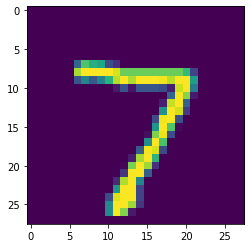

In [10]:
# 加载测试数据集
test_loader = paddle.io.DataLoader(test_dataset, batch_size=64, drop_last=True)
mnist.eval()
for batch_id, data in enumerate(test_loader()):
    x_data = data[0] 
    predicts = mnist(x_data)
    # 获取预测结果
print("predict finished")

# 从测试集中取出一组数据
img, label = test_loader().next()

# 执行推理并打印结果
pred_label = mnist(img)[0].argmax()
print('true label: {}, pred label: {}'.format(label[0].item(), pred_label[0].item()))
# 可视化图片
from matplotlib import pyplot as plt
plt.imshow(img[0][0])